# Quantum Boltzmann Machine 

In this section we will introduce a probabilistic model such as the Boltzmann Machine in its quantum version, which generates a distribution, $P(\vec{x})$, from a set of between-samples and can generate new samples.


## Introduction
 
One focus of machine learning is probabilistic modelling, in which a probability distribution is obtained from a finite set of samples. If the training process is successful, the learned distribution $P(\vec{x})$ has sufficient similarity to the actual distribution of the data that it can make correct predictions about unknown situations. Depending on the details of the distributions and the approximation technique, machine learning can be used to perform classification, clustering, compression, denoising, inpainting, or other tasks 1. In recent years the popularity of different applications using quantum computing has increased, this tutorial is based on generating one of the machine learning models in order to facilitate training. The purpose of this tutorial is to explain a probabilistic model based on the Boltzmann distribution, i.e. a Quantum Boltzmann Machine (QBM).

    
## Classical Boltzmann Machines

 
Boltzmann Machines (BMs) offer a powerful framework for modelling probability distributions. These types of neural networks use an undirected graph structure to encode relevant information. More precisely,the respective information is stored in bias coefficients and connection weights of network nodes, which are typically related to binary spin-systems and grouped into those that determine the output, the visible nodes, and those that act as latent variables, the hidden nodes [1], [2]. 

    
    
###  Applications

Applications have been studied in a large variety of domains such as the analysis of quantum many-body systems, statistics, biochemistry, social networks, signal processing and finance [2].   
 


## Quantum Boltzmann Machine 

![Image outlining the general structure of a quantum Boltzmann machine](images/qbm/qbm-scheme.svg)

Figure 1. General structure of a QBM.

Quantum Boltzmann Machines (QBMs) are a natural adaption of BMs to the quantum computing framework. Instead of an energy function with nodes being represented by binary spin values, QBMs define the underlying network using a Hermitian operator, a parameterized Hamiltonian.

1. Initialize circuit with random parameters $\vec{\theta} = (\theta^1, \dots, \theta^n)$
2. Measurements
3. Estimate mismatch between data and quantum outcomes
4. Update $\vec{\theta}$, and repeat 2 through 4 until covergence

The image below outlines the processes in a quantum Boltzmann machine:

![Image outlining the process of a quantum Boltzmann machine](images/qbm/qbm-2.svg) 


## Implementation
 
This example is based on the following article : *Benedetti, M., Garcia-Pintos, D., Perdomo, O. et al. A generative modeling approach for benchmarking and training shallow quantum circuits. npj Quantum Inf 5, 45 (2019). https://doi.org/10.1038/s41534-019-0157-8*

To begin this Tutorial we must call the necessary methods to generate circuits and that can be variational as is the case of the class [ParameterVector](https://qiskit.org/documentation/stubs/qiskit.circuit.ParameterVector.html).


In [1]:
import numpy as np
from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector

# Classes to work with three optimizers
from qiskit.algorithms.optimizers import NELDER_MEAD, SPSA, COBYLA

# For visualizations
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram

###   Dataset

Considering the Bars and Stripes (or BAS) dataset, which is composed of binary images of size 2x2, for this tutorial only a subset that is enclosed in a circle is used, as follows

![dataset](images/qbm/dataset.svg)

Figure 3. BAS dataset. 




###   Mapping image to qubits

There are various ways of mapping values to qubits as we saw in the Data Encoding section, as these are binary images, i.e. they can only take 2 values, black-white, 0-255, 0-1. To work on the quantum computer, the Basis Encoding method will be used to convert images into states, i.e. each pixel is represented as a qubit, being as described in the following figure

![image to qubit mapping](images/qbm/data-mapping-key.svg)

Figure 4. Image to quantum state.


now consider the next conditions:
- if the pixel is white, then the qubit value state is 0,
- if the pixel is Black, then the qubit value state is 1.

For example in Figure 4, the image of size $2 \times 2$ can be rewritten into a matrix

$$\begin{pmatrix}
 c_0r_0 & c_0r_1\\
 c_1r_0 & x_1r_1
\end{pmatrix}.  (1)$$


Based on the conditions, it can be seen that for the pixel at position $c_0r_0$  is white, and this is equivalent to the qubit $|q_0\rangle$, then its state value is $|0\rangle$; this logic is performed with pixels $c_0r_1$,$c_1r_0$,$c_1r_1$ which are the qubits $|q_1\rangle,|q_2\rangle,|q_3\rangle$ respectively, as they are all white color their  state would be $|0\rangle$ for all of them. The result is the quantum state $|0000\rangle$ of the 4 qubits.




Performing this process for each of the images of the subset would look like this

![Each image in the dataset, mapping to computational basis states](images/qbm/dataset-mapping-examples.svg)

Figura 5. Mapping the size in qubits.


in total are six quantum states, this can be rewritten as the linear combination, for this purpose it is necessary to consider the characteristic that 

$$\sum_{i=0}^{2^n} | \alpha_i |^2 = 1  \text{  (2)}$$ 

where $n$ is the number of the qubits and $\alpha_i \in \mathbb{C}$ are the scalar values of each state, for this case we consider them purely real, and as each state has the same probability of being measured the following quantum state remains  $|\psi\rangle$,

$$|\psi \rangle =  \frac{1}{\sqrt{6}} (|0000\rangle+|0011\rangle+|0101\rangle+|1010\rangle+|1100\rangle+|1111\rangle)$$

 which represents a probability distribution $P(x)$.
 
 
Note: Check that each  quantum state representate a binary number and that in a decimal value, i.e.:

- $|0000 \rangle \rightarrow 0$
- $|0011 \rangle \rightarrow 3$ 
- $|0101 \rangle \rightarrow 5$ 
- $|1010 \rangle \rightarrow 10$ 
- $|1100 \rangle \rightarrow 12$ 
- $|1111 \rangle \rightarrow 15$ 
 
Question  What happens if we use other state of interes with image of size 3x3?  

Starting $P(x)$ with the variablepx_output to generate the equivalent state it is necessary that

In [2]:
num_qubits = 4
init_list = [0,3,5,10,12,15] # indices of interest 
# create all-zeros array of size num_qubits^2
px_output = Statevector.from_label('0'*num_qubits)

for init_value in init_list:
    px_output.data[init_value] = 1
px_output /= np.sqrt(len(init_list)) # normalize the statevector
px_output = Statevector(px_output)
print(px_output)  # print to check it's correct

# px_output = [1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1]/16 expected output

Statevector([0.40824829+0.j, 0.        +0.j, 0.        +0.j,
             0.40824829+0.j, 0.        +0.j, 0.40824829+0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.40824829+0.j, 0.        +0.j,
             0.40824829+0.j, 0.        +0.j, 0.        +0.j,
             0.40824829+0.j],
            dims=(2, 2, 2, 2))


it is important to prove that the state vector satisfies the characteristics of eq(2), this is possible if we use the next line 

In [3]:
np.sum(px_output.data**2)

(1.0000000000000002+0j)

The result must be a uniform distribution for the 6 states:0000, 0011, 0101, 1010, 1100, 1111 otherwise it is 0, the probability can be obtained from the following expression $|\frac{1}{6}|^2 = \frac{1}{6} =0.167 $.

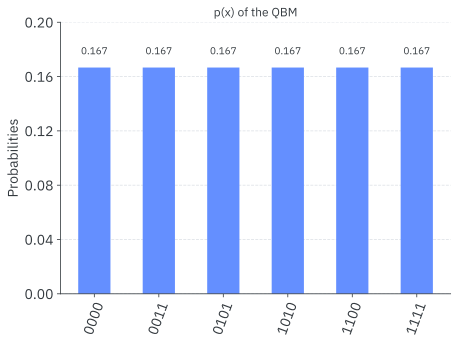

In [4]:
dict_px_output = px_output.probabilities_dict()
plot_histogram(dict_px_output, title='p(x) of the QBM')

###   Design a Variational Quantum Circuit (Layer)

The QBM design based on [3] requires a Variational Quantum Circuit or [ansatz](https://qiskit.org/documentation/tutorials/circuits_advanced/01_advanced_circuits.html) that we can name as a layer and this can be repeated L times in order to obtain the desired distribution, in our case ofpx_output

Qiskit has some ansatz already implemented as is the case of [RealAmplitudes](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html), for this method requires the parameters number of qubits and the number of repetitions or *L* number of layers.

/usr/local/lib/python3.9/site-packages/sympy/core/expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


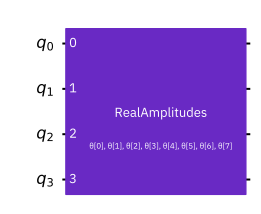

In [5]:
# import for the ansatz is in circuit.library from qiskit
from qiskit.circuit.library import RealAmplitudes
# this ansatz only needs the number of the qubits and the repetitions
ansatz_example = RealAmplitudes(num_qubits, reps=1) 

ansatz_example.draw()

It is important to know that there are other ansatz other than RealAmplitudes in Qiskit [here](https://qiskit.org/documentation/apidoc/circuit_library.html#n-local-circuits), except for this tutorial it will be based on an ansatz that follows the idea of the paper [3],"in this work, we use arbitrary single qubit rotations for the odd layers, and Mølmer-Sørensen XX gates for the even layers", we need remark the paper works in a trapped ion architecture. Design the ansatzes must use [ParameterVector](https://qiskit.org/documentation/stubs/qiskit.circuit.ParameterVector.html) class, in order to generate gates that can vary their values.


Question  What happens if we use a predefined ansatz for this problem?  

In [6]:
## Design any ansatz
# Here, we use arbitrary single qubit rotations for the odd layers,
# and Mølmer-Sørensen XX gates for the even layers

def ansatz_odd(n,parameters):
    # arbitrary single qubit rotations for the odd layer
    qc = QuantumCircuit(n) 
    for i in range(n):
        # Use variable value for ry with the values parameters[i]
        qc.u(parameters[3*i],parameters[1+(3*i)],parameters[2+(3*i)],i)
    return qc

def ansatz_even(n,parameters):
    # Mølmer-Sørensen XX gates for the even layer
    qc = QuantumCircuit(n)
    k = n//2
    for i in range(k):
        qc.rxx(parameters[i],i*2,(2*i)+1)
    for i in range(k):
        qc.rxx(parameters[i+k],k-i-1,k)
    for i in range(k):
        qc.rxx(parameters[i+k*2],k-i-1,k+1)
    return qc

The odd layer is possible consider the arbitrary single qubit rotation has the form $U\left(\theta_{l}^{j}\right)=R_{z}\left(\theta_{l}^{j, 1}\right) R_{x}\left(\theta_{l}^{j, 2}\right) R_{z}\left(\theta_{l}^{j, 3}\right)$. This is possible if we use the [U gate](https://qiskit.org/documentation/stubs/qiskit.circuit.library.UGate.html), with a list of parameters.

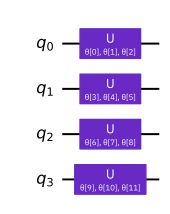

In [7]:
# depending on design, we can change the num_params value
num_params_odd = 12 # for 4 qubits we need 12 parameters
parameters_odd = ParameterVector('θ', num_params_odd)
ansatz_odd(num_qubits,parameters_odd).draw()

For the case of the even layer, MGS XX can be represented in [4], it tells us that from the gate summation ${RXX}(\theta)$ in all qubits of the quantum circuit we can obtain such a circuit.

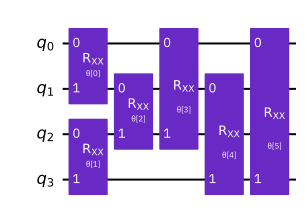

In [8]:
num_params_even = 6 # for 4 qubits we need 6 parameters
parameters_even = ParameterVector('θ', num_params_even)
ansatz_even(num_qubits,parameters_even).draw()

### Applying n layers

Due to a Qiskit method in the QuantumCircuit object our both ansatz can be converted into a quantum gate and we can indicate the number of repeats with the variablenum_layersthat are required to fit the expected output distribution.

In [9]:
# ansatz to quantum gate
def gate_layer(n, params,flag):
    if flag == 1:
        parameters = ParameterVector('θ', num_params_odd)
        qc = ansatz_odd(n,parameters) # call the odd layer
    else:
        parameters = ParameterVector('θ', num_params_even)
        qc = ansatz_even(n,parameters) # call the even layer
    params_dict = {}
    j = 0
    for p in parameters:
        # The name of the value will be the string identifier and an
        # integer specifying the vector length
        params_dict[p] = params[j] 
        j += 1
    # Assign parameters using the assign_parameters method
    qc = qc.assign_parameters(parameters = params_dict)
    qc_gate = qc.to_gate()
    qc_gate.name = "layer" # To show when we display the circuit
    return qc_gate # return a quantum gate

We are going to make a quantum circuit with 3 layers, at the same time it is important to consider that there are two gates that are interleaved for each layer and these have different amount of parameters, so we look for the one that has more of these, i.e. 
```max(paremers_odd,parameters_even)```, and that only the necessary ones are read per layer.

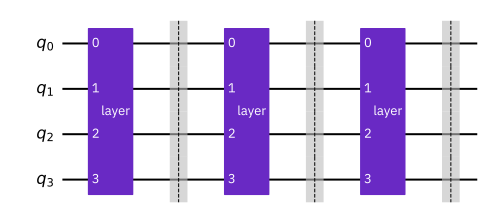

In [10]:
# example of a quantum circuit
num_layers = 3
list_n = range(num_qubits)
num_params = max(num_params_odd, num_params_even)
params = np.random.random([num_layers*num_params]) # all parameters
qc_gate = QuantumCircuit(num_qubits)

for i in range(len(params)//num_params):
    # apply a function to consider m layers
    qc_gate.append(gate_layer(num_qubits,
                              params[num_params*i:num_params*(i+1)],
                              (i+1)%2),
                   list_n)
    qc_gate.barrier()
qc_gate.draw()

In order to verify that they are interleaving we use the decompose() method, to see that the same circuit is repeated in layer 1 and layer 3, using the odd layer, and the second circuit is the even layer.

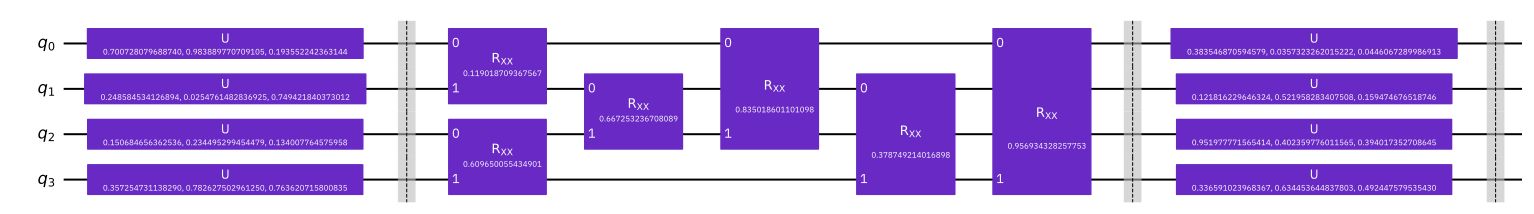

In [11]:
qc_gate.decompose().draw(fold=-1, )

Suggestion  play with the number of layers and see how is the draw output  

###  Build all the algorithm

At this point we have the data mapping process and the quantum circuit that represents the QBM, for this we need the optimization section and the cost function to be evaluated, for this we use the advantages of quantum computing in the model and the classical one in the optimization, as shown in Figure 6.


![High-level outline of a variational quantum algorithm](images/qbm/vqc.svg)

Figure 6. Hybrid algorithm process.

###  Cost Function

Consider the data set BAS, our goal is obtain an approximation to the target probability distributionpx_outputor $P(\vec{x})$ . This is possible with a quantum circuit with gates parametrized by a vector $\vec{\theta}$,where the layer index $l$ runs from 0 to $d$, with $d$ the maximum depth of the quantum circuit [5], prepares a wave function $|\psi(\vec{\theta})\rangle$ from which probabilities are obtained to $P(\vec{x})=|\langle\vec{x} \mid \psi(\vec{\theta})\rangle|^{2}$.Minimization of this quantity is directly related to the minimization of a well known cost function: the negative [log-likelihood](https://en.wikipedia.org/wiki/Likelihood_function) $\mathcal{C}(\vec{\theta})=-\frac{1}{D} \sum_{d=1}^{D} \ln \left(P\left(\vec{x}^{(d)}\right)\right) .$ Is important consider that all the probabilities are estimated from a finite number of measurements and a way to avoid singularities in the cost function [3], we use a simple variant


$\mathcal{C}(\vec{\theta})=-\frac{1}{D} \sum_{d=1}^{D} \ln \left(\max \left(\varepsilon, P_{\vec{\theta}}\left(\vec{x}^{(d)}\right)\right)\right)$ (3) 

 where $\epsilon>0 $ is a small number to be chosen. Following this equation we have a method calledboltzman_machine(params) which is the function that integrates all the quantum process and the cost function required to perform the optimization.

In [12]:
def boltzman_machine(params):
    n = 4
    D = int(n**2)
    cost = 0
    list_n = range(n)
    
    qc = QuantumCircuit(n)
    for i in range(len(params)//num_params):
        qc.append(gate_layer(n,
                             params[num_params*i:num_params*(i+1)],
                             (i+1)%2),
                  list_n)
    shots = 8192
    sv_sim = Aer.get_backend('statevector_simulator')
    result = execute(qc, sv_sim).result()
    statevector = result.get_statevector(qc)
    for j in range(D):
        cost += np.log10(max(0.001,
                             statevector[j].real*px_output.data[j].real
                             +(statevector[j].imag*px_output.data[j].imag)
                            )
                        )
    cost = -cost/D
    return cost

num_layers = 6
params = np.random.random([num_layers*num_params])    
boltzman_machine(params)

2.526632878169296

Having the quantum process that returns the cost, we use the classical process implemented in Qiskit, which has a series of classical [optimizers](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.html).

Consider 10 epoch with 500 iterations.

In [13]:
cost_cobyla = []
cost_nm = []
cost_spsa = []

params_cobyla = params
params_nm = params
params_spsa = params
epoch = 10
maxiter = 500

for i in range(epoch):
    optimizer_cobyla = COBYLA(maxiter=maxiter)
    ret = optimizer_cobyla.optimize(num_vars=len(params),
                                    objective_function=boltzman_machine,
                                    initial_point=params_cobyla)
    params_cobyla = ret[0]
    cost_cobyla.append(ret[1])
    
    optimizer_nm = NELDER_MEAD(maxiter=maxiter)
    ret = optimizer_nm.optimize(num_vars=len(params),
                                objective_function=boltzman_machine,
                                initial_point=params_nm)
    params_nm = ret[0]
    cost_nm.append(ret[1])
    
    optimizer_spsa = SPSA(maxiter=maxiter)
    ret = optimizer_spsa.optimize(num_vars=len(params),
                                  objective_function=boltzman_machine,
                                  initial_point=params_spsa)
    params_spsa = ret[0]
    cost_spsa.append(ret[1])

From the plot of each result we can see that the best optimizer is COBYLA for this algorithm.

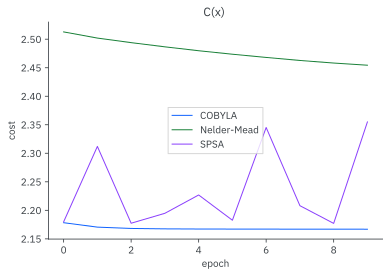

In [14]:
xfit = range(epoch)
plt.plot(xfit, cost_cobyla, label='COBYLA')
plt.plot(xfit, cost_nm, label='Nelder-Mead')
plt.plot(xfit, cost_spsa, label='SPSA')

plt.legend()
plt.title("C(x) ")
plt.xlabel("epoch")
plt.ylabel("cost");

 Qiskit has the opportunity to be able to work with more optimisers that are [here](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.html) .

 
Suggestion  Try changing the value of themaxitervariable and the optimisers in order to identify the best case.   

the boltzman_machine_valid method is performed to give us  $P(\vec{x})=|\langle\vec{x} \mid \psi(\vec{\theta})\rangle|^{2}$

In [15]:
def boltzman_machine_valid(params):
    n = 4
    list_n = range(n)
    qc = QuantumCircuit(n)
    for i in range(len(params)//num_params):
        qc.append(gate_layer(n,
                             params[num_params*i:num_params*(i+1)],
                             (i+1)%2),
                  list_n)
    shots = 8192
    simulator = Aer.get_backend('statevector_simulator')
    result = execute(qc, simulator).result()
    return result

### Visualization

We obtain the output of the three different optimizers

In [16]:
psi_vqc_spsa =  boltzman_machine_valid(params_spsa)
psi_spsa = psi_vqc_spsa.get_statevector()

psi_vqc_nm =  boltzman_machine_valid(params_nm)
psi_nm = psi_vqc_nm.get_statevector()

psi_vqc_cobyla =  boltzman_machine_valid(params_cobyla)
psi_cobyla = psi_vqc_cobyla.get_statevector()

In order to compare all the results of each optimizer with the expected output, the plot_histogram method is used and we can see at a glance the similarities of each distribution.

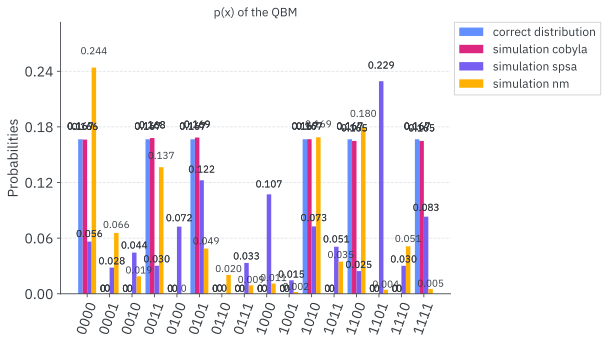

In [17]:
psi_dict_cobyla = psi_vqc_cobyla.get_counts()
psi_dict_spsa = psi_vqc_spsa.get_counts()
psi_dict_nm = psi_vqc_nm.get_counts()

plot_histogram([dict_px_output, psi_dict_cobyla,
                psi_dict_spsa, psi_dict_nm],
               title='p(x) of the QBM',
               legend=['correct distribution', 'simulation cobyla',
                       'simulation spsa', 'simulation nm'])

It can be seen that of all the visualization methods, the closest is the one used with COBYLA, which will be considered to generate new samples from this dataset. But you are still invited to look for other optimizers and change the number of the maxiter variable.

### Using our QBM 

To apply this circuit we use the final parameters and see what kind of results they produce as images. This is shown below.

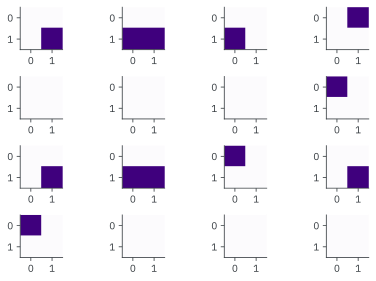

In [18]:
def boltzman_machine_valid_random(params):
    n = 4
    list_n = range(n)
    qc = QuantumCircuit(n,n)
    for i in range(len(params)//num_params):
        qc.append(
            gate_layer(n,
                       params[num_params*i:num_params*(i+1)],(i+1)%2),
            list_n)
    qc.measure(list_n,list_n)
    shots = 1
    job = execute( qc, Aer.get_backend('qasm_simulator'),shots=shots )
    counts = job.result().get_counts()
    return counts.keys()

# Plot results as 2x2 images
matrix = np.zeros((2,2))
for i in range(0,16):
    img = list(boltzman_machine_valid_random(params))[0]
    matrix[0][0] = int(img[0])
    matrix[0][1] = int(img[1])
    matrix[1][0] = int(img[2])
    matrix[1][1] = int(img[3])
    
    plt.subplot(4, 4, 1+i)
    plt.imshow(matrix)
plt.tight_layout();

 Check how many images do not follow the expected distribution. 

Depending on the Dial distributor we expect with higher probability the desired states, but if there is a percentage of an incorrect state it may sometimes appear with its respective probability.


###   Noise model

We managed to realize a quantum circuit that is a QBM and to see its effectiveness in a more complex environment than the simulation we will perform the process in a noise model, for this we must consider having our paltaform key in our system.

For this example we will use the real `ibmq_lima` gate, but you can choose from the ones found [here](https://quantum-computing.ibm.com/services?services=systems).

In [19]:
from qiskit.test.mock import FakeLima
backend = FakeLima()

# Uncomment the code below to use the real device:
# from qiskit import IBMQ# provider = IBMQ.load_account()
# backend = provider.get_backend('ibmq_lima')

We can use the ibmq_lima features for our simulator and it can perform at the same characteristics of this one. 

To know more about the features of the NoiseModel method [here](https://qiskit.org/documentation/stubs/qiskit.providers.aer.noise.NoiseModel.html?highlight=noisemodel)

In [20]:
from qiskit.providers.aer.noise import NoiseModel
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

We performed the same process that we did previously in simulation but adapted it with the noise model variables.

In [21]:
def noise_boltzman_machine(params):
    n = 4
    D = int(n**2)
    cost = 0
    list_n = range(n)
    
    qc = QuantumCircuit(n)
    for i in range(len(params)//num_params):
        qc.append(gate_layer(n,
                             params[num_params*i:num_params*(i+1)],
                             (i+1)%2),
                  list_n)
    shots = 8192
    simulator = Aer.get_backend('statevector_simulator')
    result = execute(qc, simulator, shots = 8192,
                    # These parameters are for our noise model:
                    coupling_map=coupling_map,
                    basis_gates=basis_gates,
                    noise_model=noise_model,
                    cals_matrix_refresh_period=30).result()
                    
    statevector = result.get_statevector(qc)
    for j in range(D):
        cost += np.log10(max(0.001,
                             statevector[j].real*px_output.data[j].real
                             +(statevector[j].imag*px_output.data[j].imag)
                            )
                        )
    cost = -cost/D
    return cost

num_layers = 6
noise_params = np.random.random([num_layers*num_params])    
noise_boltzman_machine(noise_params)

2.515085270247856

Consider run but using a new variable callnoise_params and we can consider the best optimizer,COBYLAin stead of using the others one.

In [22]:
print("cost:")
print(noise_boltzman_machine(noise_params))

for i in range(10):
    optimizer = COBYLA(maxiter=500)
    ret = optimizer.optimize(num_vars=len(noise_params),
                             objective_function=noise_boltzman_machine,
                             initial_point=noise_params)
    noise_params = ret[0]
    print(ret[1])

cost:
2.860379448430914
2.2843559495106893
2.2876193723013847
2.370747462669242
2.4158515841223926
2.3237948329775584
2.288052241158968
2.3179851856821525
2.3626775056067344
2.3128664509231
2.260656287576424


At this point we have the distribution $P(x)$ result of the Noise model

In [23]:
noise_psi_vqc = boltzman_machine_valid(noise_params)
noise_psi_vqc.get_statevector()

array([-0.33960127+0.22331739j,  0.18205907+0.07271958j,
        0.00872472+0.19215568j, -0.14121486-0.03480634j,
        0.058742  -0.0041664j , -0.21355708-0.05223143j,
       -0.0012786 -0.22485038j,  0.11172433-0.26672099j,
       -0.23779037-0.13522476j, -0.16216589+0.04684949j,
       -0.25834999+0.12494476j,  0.23195429-0.08442631j,
       -0.24778015-0.20101767j,  0.16522676+0.30229775j,
        0.09639447-0.16469021j, -0.21207466+0.06117737j])

The expected output, the best simulated result and the best simulated result using a NoiseModel are compared.

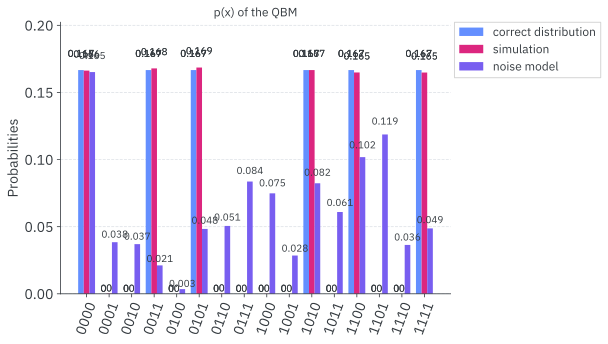

In [24]:
noise_model_psi = noise_psi_vqc.get_counts()
plot_histogram([dict_px_output, psi_dict_cobyla, noise_model_psi],
               title='p(x) of the QBM',
               legend=['correct distribution', 'simulation',
                       'noise model'])

Having each result follow the trend of the expected output, but with certain errors, we can see that our circuit is working, and we can continue this by trying to obtain new samples from the circuit with noise.

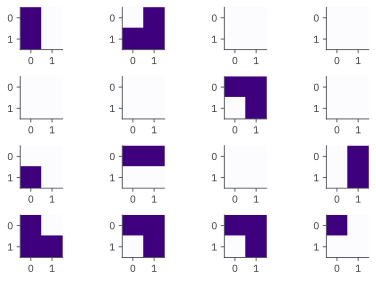

In [25]:
matrix = np.zeros((2,2))
for i in range(0,16):
    img = list(boltzman_machine_valid_random(noise_params))[0]
    matrix[0][0] = int(img[0])
    matrix[0][1] = int(img[1])
    matrix[1][0] = int(img[2])
    matrix[1][1] = int(img[3])    
    plt.subplot(4 , 4 , 1+i)
    plt.imshow(matrix)
plt.tight_layout();

 Check how many images do not follow the expected distribution. 

###   Real quantum computer

The quantum instance for real free quantum computer (try to change the value for  provider.get_backend( )), in this tutorial we use the ibmq_lima the same that i nthe noise model. More information about this quantum computer you can find [here](https://quantum-computing.ibm.com/services?services=systems&system=ibmq_lima).

In [26]:
real_backend = FakeLima()
# Uncomment the code below to use a real backend:# from qiskit import IBMQ# provider = IBMQ.load_account()# real_backend = provider.get_backend('ibmq_lima')

We follow the same processing of the simulation, but in this case we use the backend which is the real computer.

In [27]:
def real_boltzman_machine(params):
    n = 4
    D = int(n**2)
    cost = 0
    list_n = range(n)
    
    qc = QuantumCircuit(n,n)
    for i in range(len(params)//num_params):
        qc.append(gate_layer(n,
                             params[num_params*i:num_params*(i+1)],
                             (i+1)%2),
                  list_n)
    qc.measure(list_n,list_n)
    shots= 8192
    result = execute(qc, real_backend,
                    shots = 8192).result()
                    
    counts = result.get_counts(qc)
    for j in range(D):
        bin_index = bin(j)[2:]
        while len(bin_index) < 4:
            bin_index = '0' + bin_index
        statevector_index = counts[bin_index]/8192
        cost += np.log10(max(0.001,
                             statevector_index*px_output.data[j].real))
    cost = -cost/D
    return cost

num_layers = 6
real_params = np.random.random([num_layers*num_params])    
real_boltzman_machine(real_params)

2.5011167790490467

For this process being a real free computer, anyone with their IBM account can use any of the free computers, so the process can take some time, for this tutorial we will only use10 iterations

In [28]:
print("cost:")
print(real_boltzman_machine(real_params))

for i in range(1):
    optimizer = COBYLA(maxiter=10)
    ret = optimizer.optimize(num_vars=len(real_params),
                             objective_function=real_boltzman_machine,
                             initial_point=real_params)
    real_params = ret[0]
    print(ret[1])

cost:
2.4908683878403566
2.48536011404098


In this point we have the result of the real quantum computer for  our QBM.

In [29]:
real_psi_vqc = boltzman_machine_valid(real_params)
real_psi_vqc.get_statevector()

array([ 0.34390847-0.42308468j,  0.20429919-0.01245902j,
        0.20227778+0.09154417j,  0.04081892+0.07153613j,
        0.19067793-0.21881602j,  0.23518624-0.21639295j,
        0.03758353+0.15531792j, -0.181845  +0.08121798j,
        0.26409386+0.04161694j, -0.11579812-0.12846314j,
       -0.09045852-0.12927443j,  0.09475358-0.17779612j,
        0.18829475+0.11932064j, -0.22738036-0.04187002j,
       -0.19606105-0.12422142j,  0.05567245-0.16181513j])

We can compare all the result in a same plot_histogram, and check the worst case is the result of the quantum real computer, that could be solve, using more iteration, mitigate the error, modified the ansatz or both.

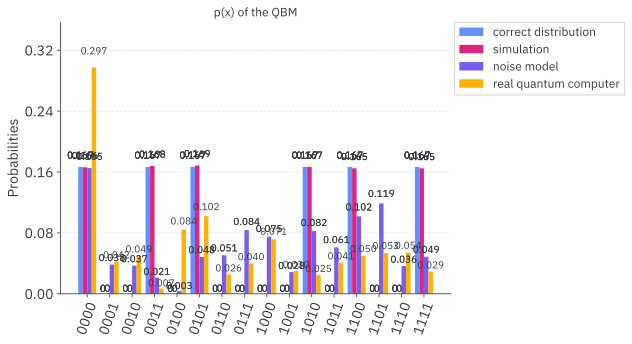

In [30]:
real_model_psi = real_psi_vqc.get_counts()
plot_histogram([dict_px_output, psi_dict_cobyla,
                noise_model_psi, real_model_psi],
               title='p(x) of the QBM',
               legend=['correct distribution', 'simulation',
                       'noise model', 'real quantum computer'])

Just to confirm what are the possible outputs of our circuit using the real computer, this is given by the type of distribution obtained from the computer.

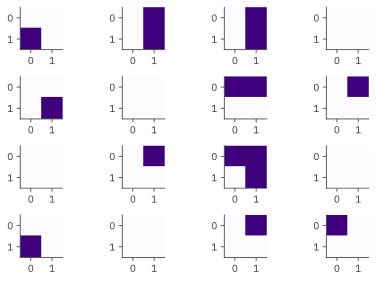

In [31]:
matrix = np.zeros((2,2))
for i in range(0,16):
    img = list(boltzman_machine_valid_random(real_params))[0]
    matrix[0][0] = int(img[0])
    matrix[0][1] = int(img[1])
    matrix[1][0] = int(img[2])
    matrix[1][1] = int(img[3])
    plt.subplot(4 , 4 , 1+i)
    plt.imshow(matrix)
plt.tight_layout();

 Check how many images do not follow the expected distribution. 

##   Another perspective

For this part we can do the same procces and using the reference [5] with the proposal to design another Ansatz model, the characteristics are:

- Using the same layer arbitrary rotation gate, 
- And employ CNOT gates with no parameters for the entangle layers.

The new ansatz it could be 

In [32]:
## Design any ansatz
# Here, we use arbitrary single qubit rotations for the odd layers,
# and Mølmer-Sørensen XX gates for the even layers
def ansatz_layer(n,parameters): # this ansatz is equivalent a layer
    qc = QuantumCircuit(n)
    for i in range(n):
        # use variable value for ry with the values parameters[i]
        qc.u(parameters[i*3],parameters[(i*3)+1],parameters[(i*3)+2],i)
    for i in range(n-1):
        qc.cx(i,i+1)
    return qc

/usr/local/lib/python3.9/site-packages/sympy/core/expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


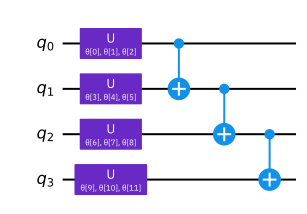

In [33]:
# depents of own design we can change the num_params value
num_params_v2 = 12# how is 4 qubits we required 12 parametrs
parameters_v2 = ParameterVector('θ', num_params_v2)

ansatz_layer(num_qubits,parameters_v2).draw()

We apply this ansatz how an gate like the previous part, how is only a gate we don't now use the parameter flag

In [34]:
# ansatz to quantum gate
def gate_layer_v2(n, params):
    parameters = ParameterVector('θ', num_params_v2)
    qc = ansatz_layer(n,parameters)
    params_dict = {}
    j = 0
    for p in parameters:
        # The name of the value will be the string identifier,
        # and an integer specifying the vector length
        params_dict[p] = params[j] 
        j += 1
    # Assign parameters using the assign_parameters method
    qc = qc.assign_parameters(parameters = params_dict)
    qc_gate = qc.to_gate()
    qc_gate.name = "layer" # To show when we display the circuit
    return qc_gate # return a quantum gate

We are going to make a quantum circuit with 3 layers, where each gate are the same structure.

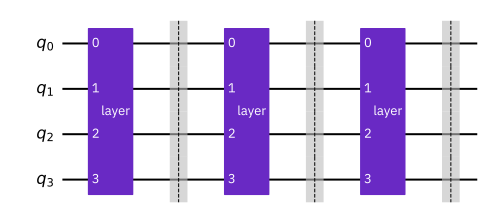

In [35]:
# example of a quantum circuit
num_layers = 3
list_n = range(num_qubits)
params = np.random.random([num_layers*num_params_v2]) # all parameters
qc_gate = QuantumCircuit(num_qubits)

for i in range(len(params)//num_params):
   # apply a function to consider m layers
    qc_gate.append(gate_layer_v2(num_qubits,
                                 params[num_params_v2*i:num_params_v2*(i+1)]),
                   list_n)
    qc_gate.barrier()
qc_gate.draw()

Now we are using decompose(), it is observed that if the new structure consists of the same circuit for each layer.

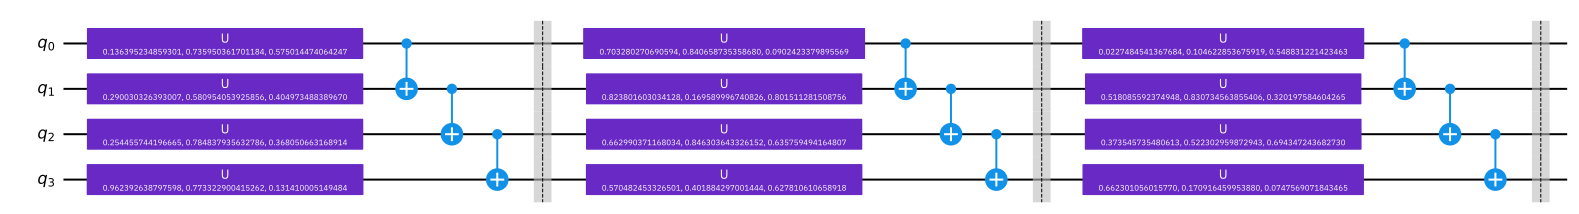

In [36]:
qc_gate.decompose().draw(fold=-1)

### Experiments

As in the previous section, we will train with simulation. In this ansatz we are using only 3 layers

In [37]:
def boltzman_machine_v2(params):
    n = 4
    D = int(n**2)
    cost = 0
    list_n = range(n)
    
    qc = QuantumCircuit(n)
    for i in range(len(params)//num_params):
        qc.append(gate_layer_v2(n,params[num_params*i:num_params*(i+1)]),
                  list_n)
    shots= 8192
    simulator = Aer.get_backend('statevector_simulator')
    result = execute(qc, simulator).result()
    statevector = result.get_statevector(qc)
    for j in range(D):
        cost += np.log10(max(0.001,
                             statevector[j].real*px_output.data[j].real
                             +(statevector[j].imag*px_output.data[j].imag)
                            )
                        )
    cost = -cost/D
    return cost

num_layers = 3
params = np.random.random([num_layers*num_params])    
boltzman_machine_v2(params)

2.7393156849239633

In [38]:
cost_cobyla = []
cost_nm = []
cost_spsa = []

params_cobyla = params
params_nm = params
params_spsa = params
epoch = 10
maxiter = 500

for i in range(epoch):
    optimizer_cobyla = COBYLA(maxiter=maxiter)
    ret = optimizer_cobyla.optimize(num_vars=len(params),
                                    objective_function=boltzman_machine_v2,
                                    initial_point=params_cobyla)
    params_cobyla = ret[0]
    cost_cobyla.append(ret[1])
    
    optimizer_nm = NELDER_MEAD(maxiter=maxiter)
    ret = optimizer_nm.optimize(num_vars=len(params),
                                objective_function=boltzman_machine_v2,
                                initial_point=params_nm)
    params_nm = ret[0]
    cost_nm.append(ret[1])
    
    optimizer_spsa = SPSA(maxiter=maxiter)
    ret = optimizer_spsa.optimize(num_vars=len(params),
                                  objective_function=boltzman_machine_v2,
                                  initial_point=params_spsa)
    params_spsa = ret[0]
    cost_spsa.append(ret[1])

The process is repeated to confirm the best optimizer using this new ansatz

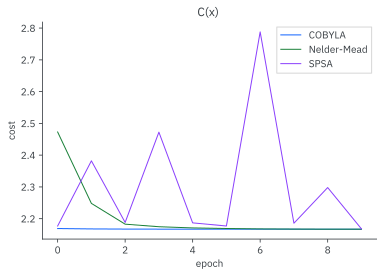

In [39]:
xfit = range(epoch)
plt.plot(xfit, cost_cobyla, label='COBYLA')
plt.plot(xfit, cost_nm, label='Nelder-Mead')
plt.plot(xfit, cost_spsa, label='SPSA')

plt.legend()
plt.title("C(x) ")
plt.xlabel("epoch")
plt.ylabel("cost")
plt.show()

In [40]:
def boltzman_machine_valid_v2(params):
    n = 4
    list_n = range(n)
    qc = QuantumCircuit(n)
    for i in range(len(params)//num_params):
        qc.append(gate_layer_v2(n,
                                params[num_params*i:num_params*(i+1)]),
                  list_n)
    shots= 8192
    simulator = Aer.get_backend('statevector_simulator')
    result = execute(qc, simulator).result()
    return result

Obtain the $P(x)$ for each optimizer

In [41]:
psi_vqc_spsa =  boltzman_machine_valid_v2(params_spsa)
psi_spsa = psi_vqc_spsa.get_statevector()

psi_vqc_nm =  boltzman_machine_valid_v2(params_nm)
psi_nm = psi_vqc_nm.get_statevector()

psi_vqc_cobyla =  boltzman_machine_valid_v2(params_cobyla)
psi_cobyla = psi_vqc_cobyla.get_statevector()

It is reconfirmed that the best case is using COBYLA

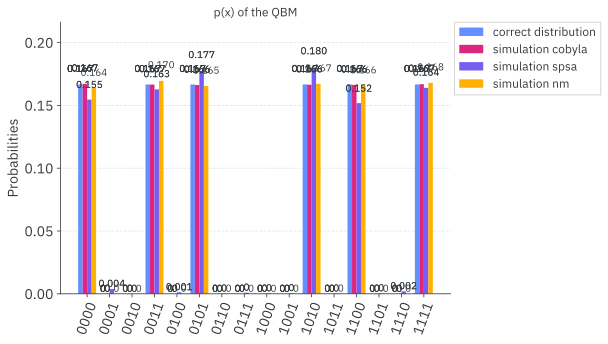

In [42]:
psi_dict_cobyla = psi_vqc_cobyla.get_counts()
psi_dict_spsa = psi_vqc_spsa.get_counts()
psi_dict_nm = psi_vqc_nm.get_counts()

plot_histogram([dict_px_output, psi_dict_cobyla,
                psi_dict_spsa, psi_dict_nm],
               title='p(x) of the QBM',
               legend=['correct distribution', 'simulation cobyla',
                       'simulation spsa', 'simulation nm'])

Applying now the distribution obtained from the simulation result

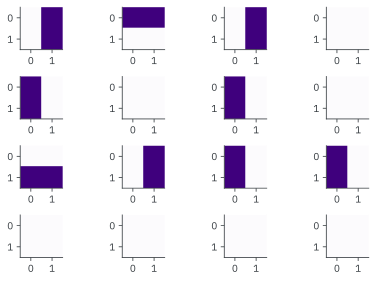

In [43]:
def boltzman_machine_valid_random_v2(params):
    n = 4
    list_n = range(n)
    qc = QuantumCircuit(n,n)
    for i in range(len(params)//num_params):
        qc.append(gate_layer_v2(n,
                                params[num_params*i:num_params*(i+1)]),
                  list_n)
    qc.measure(list_n,list_n)
    shots= 1
    job = execute( qc, Aer.get_backend('qasm_simulator'), shots=shots)
    counts = job.result().get_counts()
    return counts.keys()

matrix = np.zeros((2,2))
for i in range(0,16):
    img = list(boltzman_machine_valid_random_v2(params_cobyla))[0]
    matrix[0][0] = int(img[0])
    matrix[0][1] = int(img[1])
    matrix[1][0] = int(img[2])
    matrix[1][1] = int(img[3])
    plt.subplot(4 , 4 , 1+i)
    plt.imshow(matrix)
plt.tight_layout();

 Check how many images do not follow the expected distribution. 

 Exercise  Redesign the methods for the noise model and the real computer and see what the results are.   

 Suggestion  
    
    Modify the ansatz or use a new ansatz and apply with a simulation, noise model and real quantum computer.
       
You can use a 3x3 or 4x4 image for that consider reference [5]. 


##  Extending the problem

For this section consider this next set of images of size $3\times 3$ and generate the $|\psi\rangle$ state representing this distribution:

![dataset of 3x3 images](images/qbm/dataset-2.svg)

We'll use the mapping:

![dataset-2-mapping](images/qbm/dataset-2-mapping.svg)

You can use the "Mapping image to qubits" section above to help.

Use the next code to representate, only you need to identify the init_list values that represents our set of images. And consider for this problem 9 qubits.

In [ ]:
num_qubits_3x3 = 9

# list of indices of interest 
init_list = []  

# create all-zeros array of size num_qubits^2
px_3x3 = Statevector.from_label('0'*num_qubits)

for init_value in init_list:
    px_3x3.data[init_value] = 1
px_3x3 /= np.sqrt(len(init_list)) # normalize the statevector
px_3x3 = Statevector(px_3x3) # use Qiskit's Statevector object
print(px_3x3)  # print to check it's correct

Now we can plot the distribution $P_{3x3}(x)$ using plot_histogram method.

In [ ]:
dict_px_3x3 = px_3x3.probabilities_dict()
plot_histogram(dict_px_3x3)

Now you are going to design an ansatz, it is important to keep in mind with 9 qubits.

In [46]:
## Design your own ansatz for 9 qubits

def ansatz_layer_3x3(n,parameters): # this ansatz is equivalent a layer
    qc = QuantumCircuit(n)
    # Your code goes here
    return qc

Validate with the following code that a quantum gate is being developed from your proposed ansatz.

In [ ]:
num_params_3x3 = # check the parameters that you need in your ansatz 
num_layers =  # check the number of layers
list_n = range(num_qubits_3x3)

parameters_3x3 = ParameterVector('θ', num_params_3x3)

params = np.random.random([num_layers*num_params_3x3]) # all parameters
qc_gate_3x3 = QuantumCircuit(num_qubits_3x3)

for i in range(len(params)//num_params_3x3):
    qc_gate_3x3.append(
        ansatz_layer_3x3(num_qubits_3x3,
                         params[num_params_3x3*i:num_params_3x3*(i+1)]),
        list_n)
    qc_gate_3x3.barrier()
qc_gate_3x3.draw()

of each gate we check that it is equivalent to our ansatz using decompose()

In [ ]:
qc_gate_3x3.decompose().draw()

Based on the above examples, fill in what we are missing

In [ ]:
def boltzman_machine_3x3(params): 
    D = int(num_qubits_3x3**2)
    cost = 0
    list_n = range(num_qubits_3x3)

    qc = QuantumCircuit(num_qubits_3x3)
    for i in range(len(params)//num_params_3x3):
        qc.append(
            ansatz_layer_3x3(num_qubits_3x3,
                             params[num_params_3x3*i:num_params_3x3*(i+1)]),
            list_n)
    shots= 8192
    simulator = Aer.get_backend('statevector_simulator')
    result = execute(qc, simulator).result()
    statevector = result.get_statevector(qc)
    # how do we check the cost?
    return cost

Complete the code you have to run our QBM, for this consider an optimizer and the number of iterations to use, remember in the optimizer you have the variable maxiter

In [ ]:
params = np.random.random([num_layers*num_params_3x3])    

print("cost:")
for i in range(): #  number of iterations
    optimizer =  # which iterations and steps?
    ret = optimizer.optimize(num_vars=len(params),
                             objective_function=boltzman_machine_3x3,
                             initial_point=params)
    noise_params = ret[0]
    print(ret[1])

Now, we obtain the result in a distribution $P_{3\times 3}(x)$

In [ ]:
def boltzman_machine_valid_3x3(params):
    n=4
    list_n = range(n)
    qc = QuantumCircuit(n)
    for i in range(len(params)//num_params):
        qc.append(
            ansatz_layer_3x3(n,
                             params[num_params*i:num_params*(i+1)],
                             (i+1)%2),
            list_n)
    shots= 8192
    simulator = Aer.get_backend('statevector_simulator')
    result = execute(qc, simulator).result()
    return result

In [ ]:
psi_sv_3x3 =  boltzman_machine_valid_3x3(params)
psi_3x3 = psi_sv_3x3.get_statevector()

Finally, we plot the results

In [ ]:
psi_3x3_dict = psi_3x3.get_counts()

plot_histogram([dict_px_3x3,psi_3x3_dict], title='p(x) of the QBM',
               legend=['correct distribution', 'simulation'])

If there is no problem up to this point, you will have a distribution similar to the one we have designed,congratulations!

But for the end we leave the following question, can we decrease the number of qubits?

##   References

1. Amin, Mohammad & Andriyash, Evgeny & Rolfe, Jason & Kulchytskyy, Bohdan & Melko, Roger. (2016). Quantum Boltzmann Machine. Physical Review X. 8. 10.1103/PhysRevX.8.021050 [https://arxiv.org/pdf/1601.02036.pdf](https://arxiv.org/pdf/1601.02036.pdf) .

2. Zoufal, Christa & Lucchi, Aurelien & Woerner, Stefan. (2021). Variational quantum Boltzmann machines. Quantum Machine Intelligence. 3. 10.1007/s42484-020-00033-7 [https://arxiv.org/pdf/2006.06004.pdf](https://arxiv.org/pdf/2006.06004.pdf). 

3. Benedetti, Marcello & Garcia-Pintos, Delfina & Nam, Yunseong & Perdomo-Ortiz, Alejandro. (2018). A generative modeling approach for benchmarking and training shallow quantum circuits. npj Quantum Information. 5. 10.1038/s41534-019-0157-8. [https://arxiv.org/pdf/1801.07686.pdf](https://arxiv.org/pdf/1801.07686.pdf) [paper](https://www.nature.com/articles/s41534-019-0157-8)

4. Rudolph, Manuel & Bashige, Ntwali & Katabarwa, Amara & Johr, Sonika & Peropadre, Borja & Perdomo-Ortiz, Alejandro. (2020). Generation of High Resolution Handwritten Digits with an Ion-Trap Quantum Computer. [https://arxiv.org/pdf/2012.03924.pdf](https://arxiv.org/pdf/2012.03924.pdf)

5. Jinguo, Liu & Wang, Lei. (2018). Differentiable Learning of Quantum Circuit Born Machine. Physical Review A. 98. 10.1103/PhysRevA.98.062324. [https://arxiv.org/pdf/1804.04168.pdf](https://arxiv.org/pdf/1804.04168.pdf)

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table